In [1]:
from data_utils import *
from helpers import *
from sketchrnn import *
from sketch_transfer import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def load_sketch_transfer_model(enc1, enc2, dec):
    model = SketchTransfer_enc2(hp)
    saved_enc1 = torch.load(enc1)
    saved_enc2 = torch.load(enc2)
    saved_dec = torch.load(dec)
    model.encoder_control.load_state_dict(saved_enc1)
    model.encoder_stroke.load_state_dict(saved_enc2)
    model.decoder.load_state_dict(saved_dec)
    return model

In [3]:
model = load_sketch_transfer_model("sketch_encoder_control_sel_0.713441_epoch_780.pth", \
                                   "sketch_encoder_stroke_sel_0.713441_epoch_780.pth", \
                                  "sketch_decoder_sel_0.713441_epoch_780.pth")
model.encoder_control.train(False)
model.encoder_stroke.train(False)
model.decoder.train(False)

LSTMDecoder(
  (fc_hc): Linear(in_features=4, out_features=256, bias=True)
  (lstm): LSTM(6, 128)
  (fc_params): Linear(in_features=128, out_features=18, bias=True)
)

In [4]:
dataset = SmoothCurve("data/threecurves.csv")

Loaded 1715 segments of style 0
Shape: (1715, 4, 100)
Loaded 912 segments of style 1
Shape: (912, 4, 100)
Loaded 1469 segments of style 2
Shape: (1469, 4, 100)


Encoded style:  [0. 1. 0.]


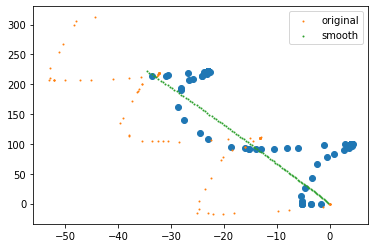

In [7]:
model.hp.temperature = 0.5
idx = 2190
data, style = dataset[idx]
inputs = torch.FloatTensor(data).cuda().unsqueeze(0).permute(2, 0, 1)
labels = torch.FloatTensor(style).cuda().unsqueeze(0)
xs, ys, dx, dy = model.test_reconstruction(inputs, labels)
plt.scatter(xs, ys)
dataset.visualize(idx)

In [8]:
def explore(zc1, zc2, zs1, zs2, t):
    plt.figure(figsize=(12, 12))
    colors = np.linspace(0.0, 1.0, 100)
    plt.cla()
    style_label = np.array([1.0, 0.0, 0.0])
    model.hp.temperature = t
    labels = torch.FloatTensor(style_label).cuda().unsqueeze(0)
            
    z_stroke = torch.FloatTensor([zs1, zs2]).cuda().unsqueeze(0)
    z_control = torch.FloatTensor([zc1, zc2]).cuda().unsqueeze(0)
    z = torch.cat((z_control, z_stroke), dim=1)

    sos = Variable(torch.Tensor([0.0, 0.0]).view(1,1,-1).cuda())
    s = sos
    seq_x = []
    seq_y = []
    hidden_cell = None
    for k in range(model.hp.Nmax):
        decoder_inputs = torch.cat([s, z.unsqueeze(0)], 2)

        # decode:
        model.pi, model.mu_x, model.mu_y, model.sigma_x, model.sigma_y, \
            model.rho_xy, hidden, cell = \
                model.decoder(decoder_inputs, z, None, hidden_cell)
        hidden_cell = (hidden, cell)
        s, dx, dy = model.sample_next_state(False)
        seq_x.append(dx)
        seq_y.append(dy)

    x_sample = np.cumsum(seq_x, 0)
    y_sample = np.cumsum(seq_y, 0)

    plt.scatter(x_sample, y_sample, s=1, c=colors)
    plt.ylim(-100, 100)
    plt.xlim(-100, 100)

In [14]:
def scatter_latent_control(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[2:, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_control.train(False)
        z, mu, sigma_hat = model.encoder_control(inputs)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)
    
def scatter_latent_control_test(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        if data[2, 0] < 0:
            data[2, :] *= -1.0
        if data[3, 0] < 0:
            data[3, :] *= -1.0
        inputs = torch.FloatTensor(data[2:, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_control.train(False)
        z, mu, sigma_hat = model.encoder_control(inputs)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)
    
def scatter_latent_stroke(dataset, style, color):
    x1 = []
    x2 = []
    for i in range(len(dataset)):
        data, labels = dataset[i]
        if labels[style] < 0.5:
            continue
        inputs = torch.FloatTensor(data[:2, :]).cuda().unsqueeze(0).permute(2, 0, 1)
        labels = torch.FloatTensor(labels).cuda().unsqueeze(0)

        model.encoder_stroke.train(False)
        z, mu, sigma_hat = model.encoder_stroke(inputs, labels)
        z = z.squeeze().detach().cpu().numpy()
        x1.append(z[0])
        x2.append(z[1])
    plt.scatter(x1, x2, s=1, c=color)

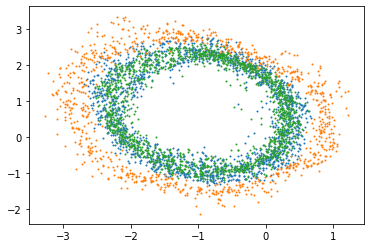

In [11]:
scatter_latent_control(dataset, 0, '#1f77b4')
scatter_latent_control(dataset, 1, '#ff7f0e')
scatter_latent_control(dataset, 2, '#2ca02c')

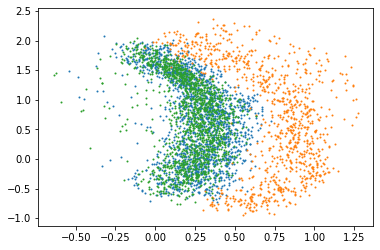

In [12]:
scatter_latent_control_test(dataset, 0, '#1f77b4')
scatter_latent_control_test(dataset, 1, '#ff7f0e')
scatter_latent_control_test(dataset, 2, '#2ca02c')

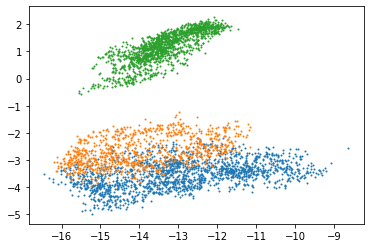

In [15]:
scatter_latent_stroke(dataset, 0, '#1f77b4')
scatter_latent_stroke(dataset, 1, '#ff7f0e')
scatter_latent_stroke(dataset, 2, '#2ca02c')

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
wig = interactive(explore, zc1=widgets.FloatSlider(min=-3, max=1), \
                  zc2=widgets.FloatSlider(min=-1.5, max=1.5), \
                  zs1=widgets.FloatSlider(min=-16, max=-11), \
                  zs2=widgets.FloatSlider(min=-5, max=2), \
                  t=widgets.FloatSlider(min=0.02, max=1))
display(wig)

interactive(children=(FloatSlider(value=0.0, description='zc1', max=1.0, min=-3.0), FloatSlider(value=0.0, des…